# Training a background - signal classifier

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import utils
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler

cwd = os.getcwd()
#import mplhep as hep
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
%load_ext autoreload
%autoreload 2

In [2]:
# parameters
bw = 1

In [3]:
# Load the ROOT file
file_paths = [f"../proj/GamGam/Data/data_{x}.GamGam.root" for x in ['A', 'B', 'C', 'D']]  # Update with your file path
tree_name = "mini"  # The tree name based on the provided data structure

In [4]:
# Example usage
# file_paths = [...]  # List of file paths to process
tree_name = "mini"  # Replace with your actual tree name
combined_df = utils.process_files_parallel(file_paths)


100%|██████████| 4/4 [02:51<00:00, 42.79s/it]


In [5]:
signal_paths = [f"../proj/GamGam/MC/mc_34{x}_gamgam.GamGam.root" for x in ['1081.ttH125', '3981.ggH125', '5041.VBFH125', '5318.WpH125J_Wincl', '5319.ZH125J_Zincl']]
signal_dfs = {}
for x, pth in zip(['tt', 'gg', 'VBF', 'Wp', 'Z'], signal_paths):
    signal_dfs[x] = utils.process_files_parallel([pth])

100%|██████████| 1/1 [00:12<00:00, 12.66s/it]


In [6]:
signal_dfs['tt'].head()

,runNumber,eventNumber,invariant_mass,photon_isTightID,photon_ptcone30,photon_etcon20,photon_trigMatched,jet_n,lep_n,met_et,met_phi
0,284500,674070,126.708076,"[True, True]","[0.0, 0.0]","[21.419776916503906, -57.1335334777832]","[True, True]",2,1,188260.203125,2.399675
1,284500,674033,128.056027,"[True, True]","[0.0, 0.0]","[-1700.162841796875, 234.0577392578125]","[True, True]",6,1,22065.056641,0.832829
2,284500,674129,118.224988,"[True, True]","[6868.8984375, 1337.672119140625]","[5708.00341796875, 2935.94970703125]","[True, True]",5,0,60637.968750,-1.505820
3,284500,674306,124.013825,"[True, False]","[0.0, 0.0]","[1173.0177001953125, -934.2145385742188]","[True, True]",4,1,159180.937500,-2.028939
4,284500,674312,126.783073,"[True, True]","[0.0, 1839.82373046875]","[-2719.704833984375, -554.8275756835938]","[True, True]",6,1,38054.359375,0.950663


In [7]:
signal_dfs['VBF'].shape

(491139, 11)

In [8]:
def split_photon_columns(df):
    """
    Split columns containing list entries (photon_isTightID, photon_ptcone30, photon_etcon20)
    into separate columns for each photon.

    Parameters:
    - df: DataFrame containing the original columns with list entries.

    Returns:
    - df: Modified DataFrame with split columns.
    """
    # Split the 'photon_isTightID' column into 'photon1_isTightID' and 'photon2_isTightID'
    df2 = df.copy()
    df2['photon1_isTightID'] = df2['photon_isTightID'].apply(lambda x: float(x[0]) if len(x) > 0 else None)
    df2['photon2_isTightID'] = df2['photon_isTightID'].apply(lambda x: float(x[1]) if len(x) > 1 else None)

    # Split the 'photon_ptcone30' column into 'photon1_ptcone30' and 'photon2_ptcone30'
    df2['photon1_ptcone30'] = df2['photon_ptcone30'].apply(lambda x: x[0] if len(x) > 0 else None)
    df2['photon2_ptcone30'] = df2['photon_ptcone30'].apply(lambda x: x[1] if len(x) > 1 else None)

    # Split the 'photon_etcon20' column into 'photon1_etcon20' and 'photon2_etcon20'
    df2['photon1_etcon20'] = df2['photon_etcon20'].apply(lambda x: x[0] if len(x) > 0 else None)
    df2['photon2_etcon20'] = df2['photon_etcon20'].apply(lambda x: x[1] if len(x) > 1 else None)

    # Drop the original columns with list entries
    df2.drop(['photon_isTightID', 'photon_ptcone30', 'photon_etcon20'], axis=1, inplace=True)

    return df2

# Apply the function to split the photon columns
split_combined_df = split_photon_columns(combined_df)
split_combined_df.head()

,runNumber,eventNumber,invariant_mass,photon_trigMatched,jet_n,lep_n,met_et,met_phi,photon1_isTightID,photon2_isTightID,photon1_ptcone30,photon2_ptcone30,photon1_etcon20,photon2_etcon20
0,297730,1540777,170.207956,"[True, True]",4,0,46997.636719,1.633800,0.0,0.0,0.000000,54738.847656,1209.197266,575.043579
1,297730,1713779,110.461619,"[True, True]",0,0,28530.031250,-2.313051,0.0,0.0,5506.991699,11680.041992,5396.233398,2005.253174
2,297730,1761929,79.565279,"[True, True]",3,0,11786.607422,2.009590,0.0,0.0,3902.340576,16578.074219,3261.838867,21145.144531
3,297730,1765304,65.320374,"[True, True]",0,0,53329.449219,-1.516588,1.0,1.0,0.000000,0.000000,-23.805450,-614.493652
4,297730,1651552,74.342131,"[True, True]",2,0,81126.132812,3.051861,0.0,0.0,8417.575195,0.000000,2472.889648,495.952545


In [9]:
split_signal_dfs = {}
for x in ['tt', 'gg', 'VBF', 'Wp', 'Z']:
    split_signal_dfs[x] = split_photon_columns(signal_dfs[x])
split_signal_dfs['tt'].head()

,runNumber,eventNumber,invariant_mass,photon_trigMatched,jet_n,lep_n,met_et,met_phi,photon1_isTightID,photon2_isTightID,photon1_ptcone30,photon2_ptcone30,photon1_etcon20,photon2_etcon20
0,284500,674070,126.708076,"[True, True]",2,1,188260.203125,2.399675,1.0,1.0,0.000000,0.000000,21.419777,-57.133533
1,284500,674033,128.056027,"[True, True]",6,1,22065.056641,0.832829,1.0,1.0,0.000000,0.000000,-1700.162842,234.057739
2,284500,674129,118.224988,"[True, True]",5,0,60637.968750,-1.505820,1.0,1.0,6868.898438,1337.672119,5708.003418,2935.949707
3,284500,674306,124.013825,"[True, True]",4,1,159180.937500,-2.028939,1.0,0.0,0.000000,0.000000,1173.017700,-934.214539
4,284500,674312,126.783073,"[True, True]",6,1,38054.359375,0.950663,1.0,1.0,0.000000,1839.823730,-2719.704834,-554.827576


## Save files before training

In [10]:
import pickle as pkl
pkl.dump(split_combined_df, open('split_combined_df.pkl','wb'))
pkl.dump(split_signal_dfs, open('split_signal_dfs.pkl','wb'))

# Load trained model

In [12]:
# Define your model class (must match the architecture used for training)
import torch.nn as nn
import torch

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 2)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_size = 11  # Number of input features (adjust based on your dataset)
model = SimpleNN(input_size)

# Load the model's state dict from the saved file
model_load_path = 'saved_model.pth'  # Path to the downloaded file
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

print("Model loaded and ready for use.")

Model loaded and ready for use.


/tmp/ipykernel_9401/2219245854.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))


In [24]:
model(X_tensor[0])

tensor([ 1.0247, -2.0167], grad_fn=<ViewBackward0>)

# Train a neuronal net

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [21]:
split_combined_df['label'] = 0  # Background label
for x in ['tt', 'gg', 'VBF', 'Wp', 'Z']:
    split_signal_dfs[x]['label'] = 1  # Signal label
deepl_df = pd.concat([split_combined_df, 
                      split_signal_dfs['tt'], 
                      split_signal_dfs['gg'], 
                      split_signal_dfs['VBF'], 
                      split_signal_dfs['Wp'], 
                      split_signal_dfs['Z'], 
                      split_signal_dfs['tt'], 
                      split_signal_dfs['gg'], 
                      split_signal_dfs['VBF'], 
                      split_signal_dfs['Wp'], 
                      split_signal_dfs['Z'], 
                      split_signal_dfs['tt'], 
                      split_signal_dfs['gg'], 
                      split_signal_dfs['VBF'], 
                      split_signal_dfs['Wp'], 
                      split_signal_dfs['Z']
                      ], ignore_index=True)

In [22]:
split_combined_df.shape, deepl_df.shape

((7772074, 15), (15075928, 15))

In [23]:
# Select feature columns and the label column
feature_columns = ['invariant_mass', 
                   'photon1_isTightID', 'photon2_isTightID', 
                   'photon1_ptcone30', 'photon2_ptcone30', 'photon1_etcon20', 
                   'photon2_etcon20', 'jet_n', 'lep_n', 'met_et', 'met_phi']
X = deepl_df[feature_columns].values
y = deepl_df['label'].values

# Normalize the features for better neural network performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a PyTorch dataset and data loader
dataset = TensorDataset(X_tensor, y_tensor)

# Split into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(SimpleNN, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 2)  # Output layer (2 classes: signal or background)

    def forward(self, x):
        # Forward pass through the network
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network
input_size = len(feature_columns)
model = SimpleNN(input_size)

In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Training complete
print('Training finished.')

Epoch [1/5], Loss: 0.0128
Epoch [2/5], Loss: 0.0127
Epoch [3/5], Loss: 0.0140
Epoch [4/5], Loss: 0.0128
Epoch [5/5], Loss: 0.0127
Training finished.


In [22]:
# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Accuracy of the model on the test set: 99.57%


# Old stuff

In [30]:
fltr = False
if filter:
    filtered_df = combined_df[
    (combined_df['photon_isTightID'].apply(lambda x: x == [True, True])) &  # Both photons are tight
    (combined_df['photon_ptcone30'].apply(lambda x: min(x) > 25)) &              # Both photons have pt > 25 GeV
    (combined_df['jet_n'] >= 2) &                                          # At least two jets
    (combined_df['met_et'] > 30) &                                         # Missing ET > 30 GeV
    (combined_df['invariant_mass'].between(100, 150))                      # Invariant mass between 110 and 140 GeV
    ]
else:
    filtered_df = combined_df
    filtered_A = df_A

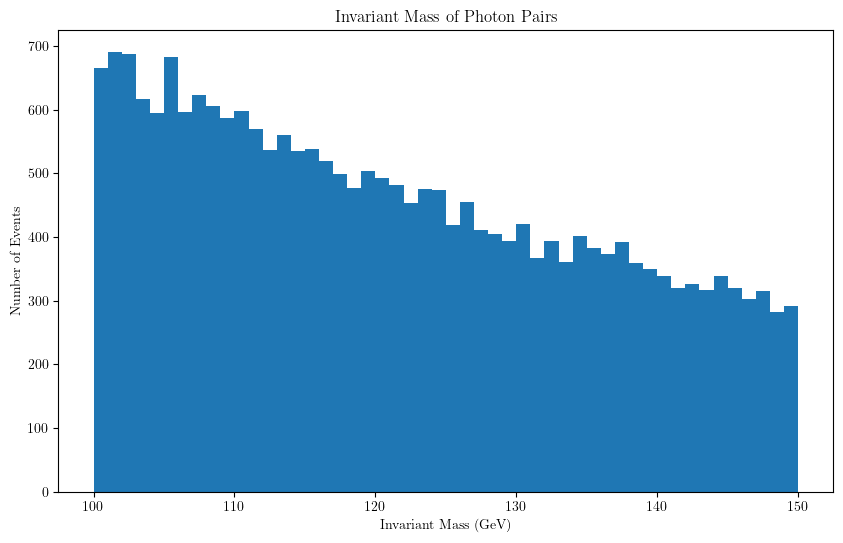

In [31]:
plt.figure(figsize=(10, 6))
counts, bin_edges, _ =  plt.hist(filtered_df["invariant_mass"], bins=np.arange(100, 150 + bw, bw))
plt.title('Invariant Mass of Photon Pairs')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()

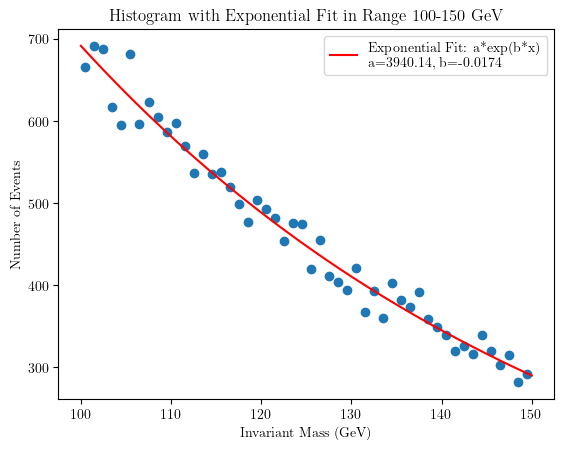

In [32]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
popt, pcov = utils.fit_histogram_exponential(counts, bin_edges, range_fit=(100, 150))

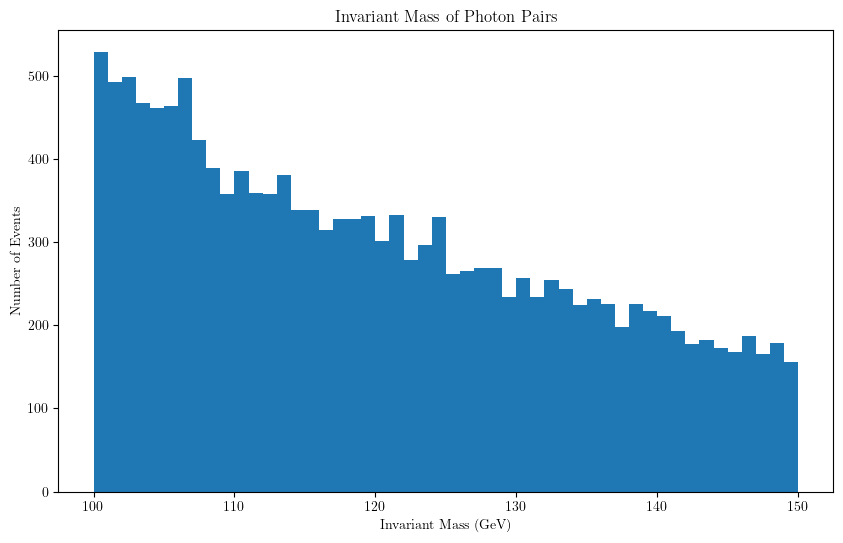

In [24]:
plt.figure(figsize=(10, 6))
counts_A, bin_edges_A, _ =  plt.hist(filtered_A["invariant_mass"], bins=np.arange(100, 150 + bw, bw))
plt.title('Invariant Mass of Photon Pairs')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()

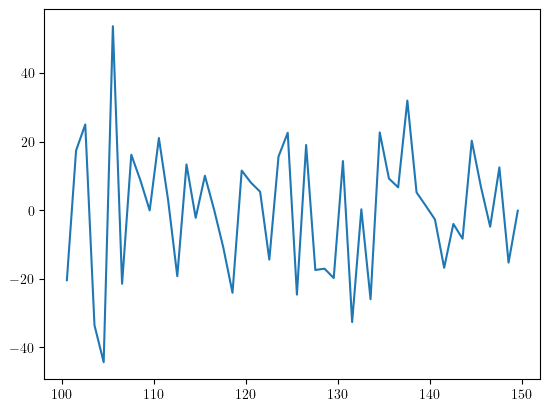

In [34]:
plt.plot(bin_centers, counts-utils.exponential_fit(bin_centers, *popt))

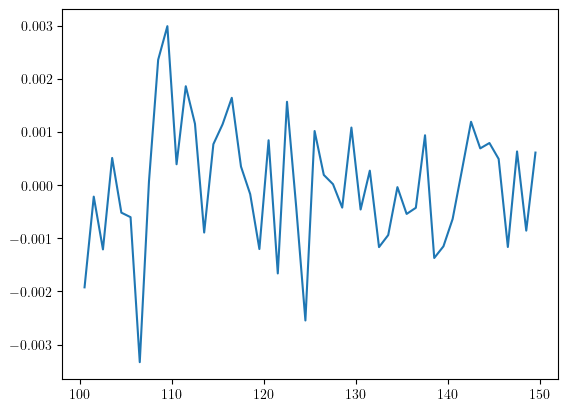

In [26]:
plt.plot(bin_centers, counts/sum(counts)-counts_A/sum(counts_A))